<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>RNNs for Timeseries Analysis</h1>
        <h1>Recurrent Neural Networks</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


np.random.seed(123)
import math

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import watermark

%load_ext watermark
%matplotlib inline

Using TensorFlow backend.


We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

keras      2.3.1
pandas     1.0.1
watermark  2.0.2
tensorflow 2.1.0
autopep8   1.5
json       2.0.9
numpy      1.18.1
Thu Mar 05 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 23641f79fd0133807880f00fa91a35bb9385f9f8


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Load dataset

GDP data from the Federal Reserve Bank [website](https://fred.stlouisfed.org/series/GDP)

In [4]:
dataset = pd.read_csv('data/GDP.csv', header=0, parse_dates=[0], index_col=0)

It's always important to see what you are doing. You can save a lot of time like this ;)

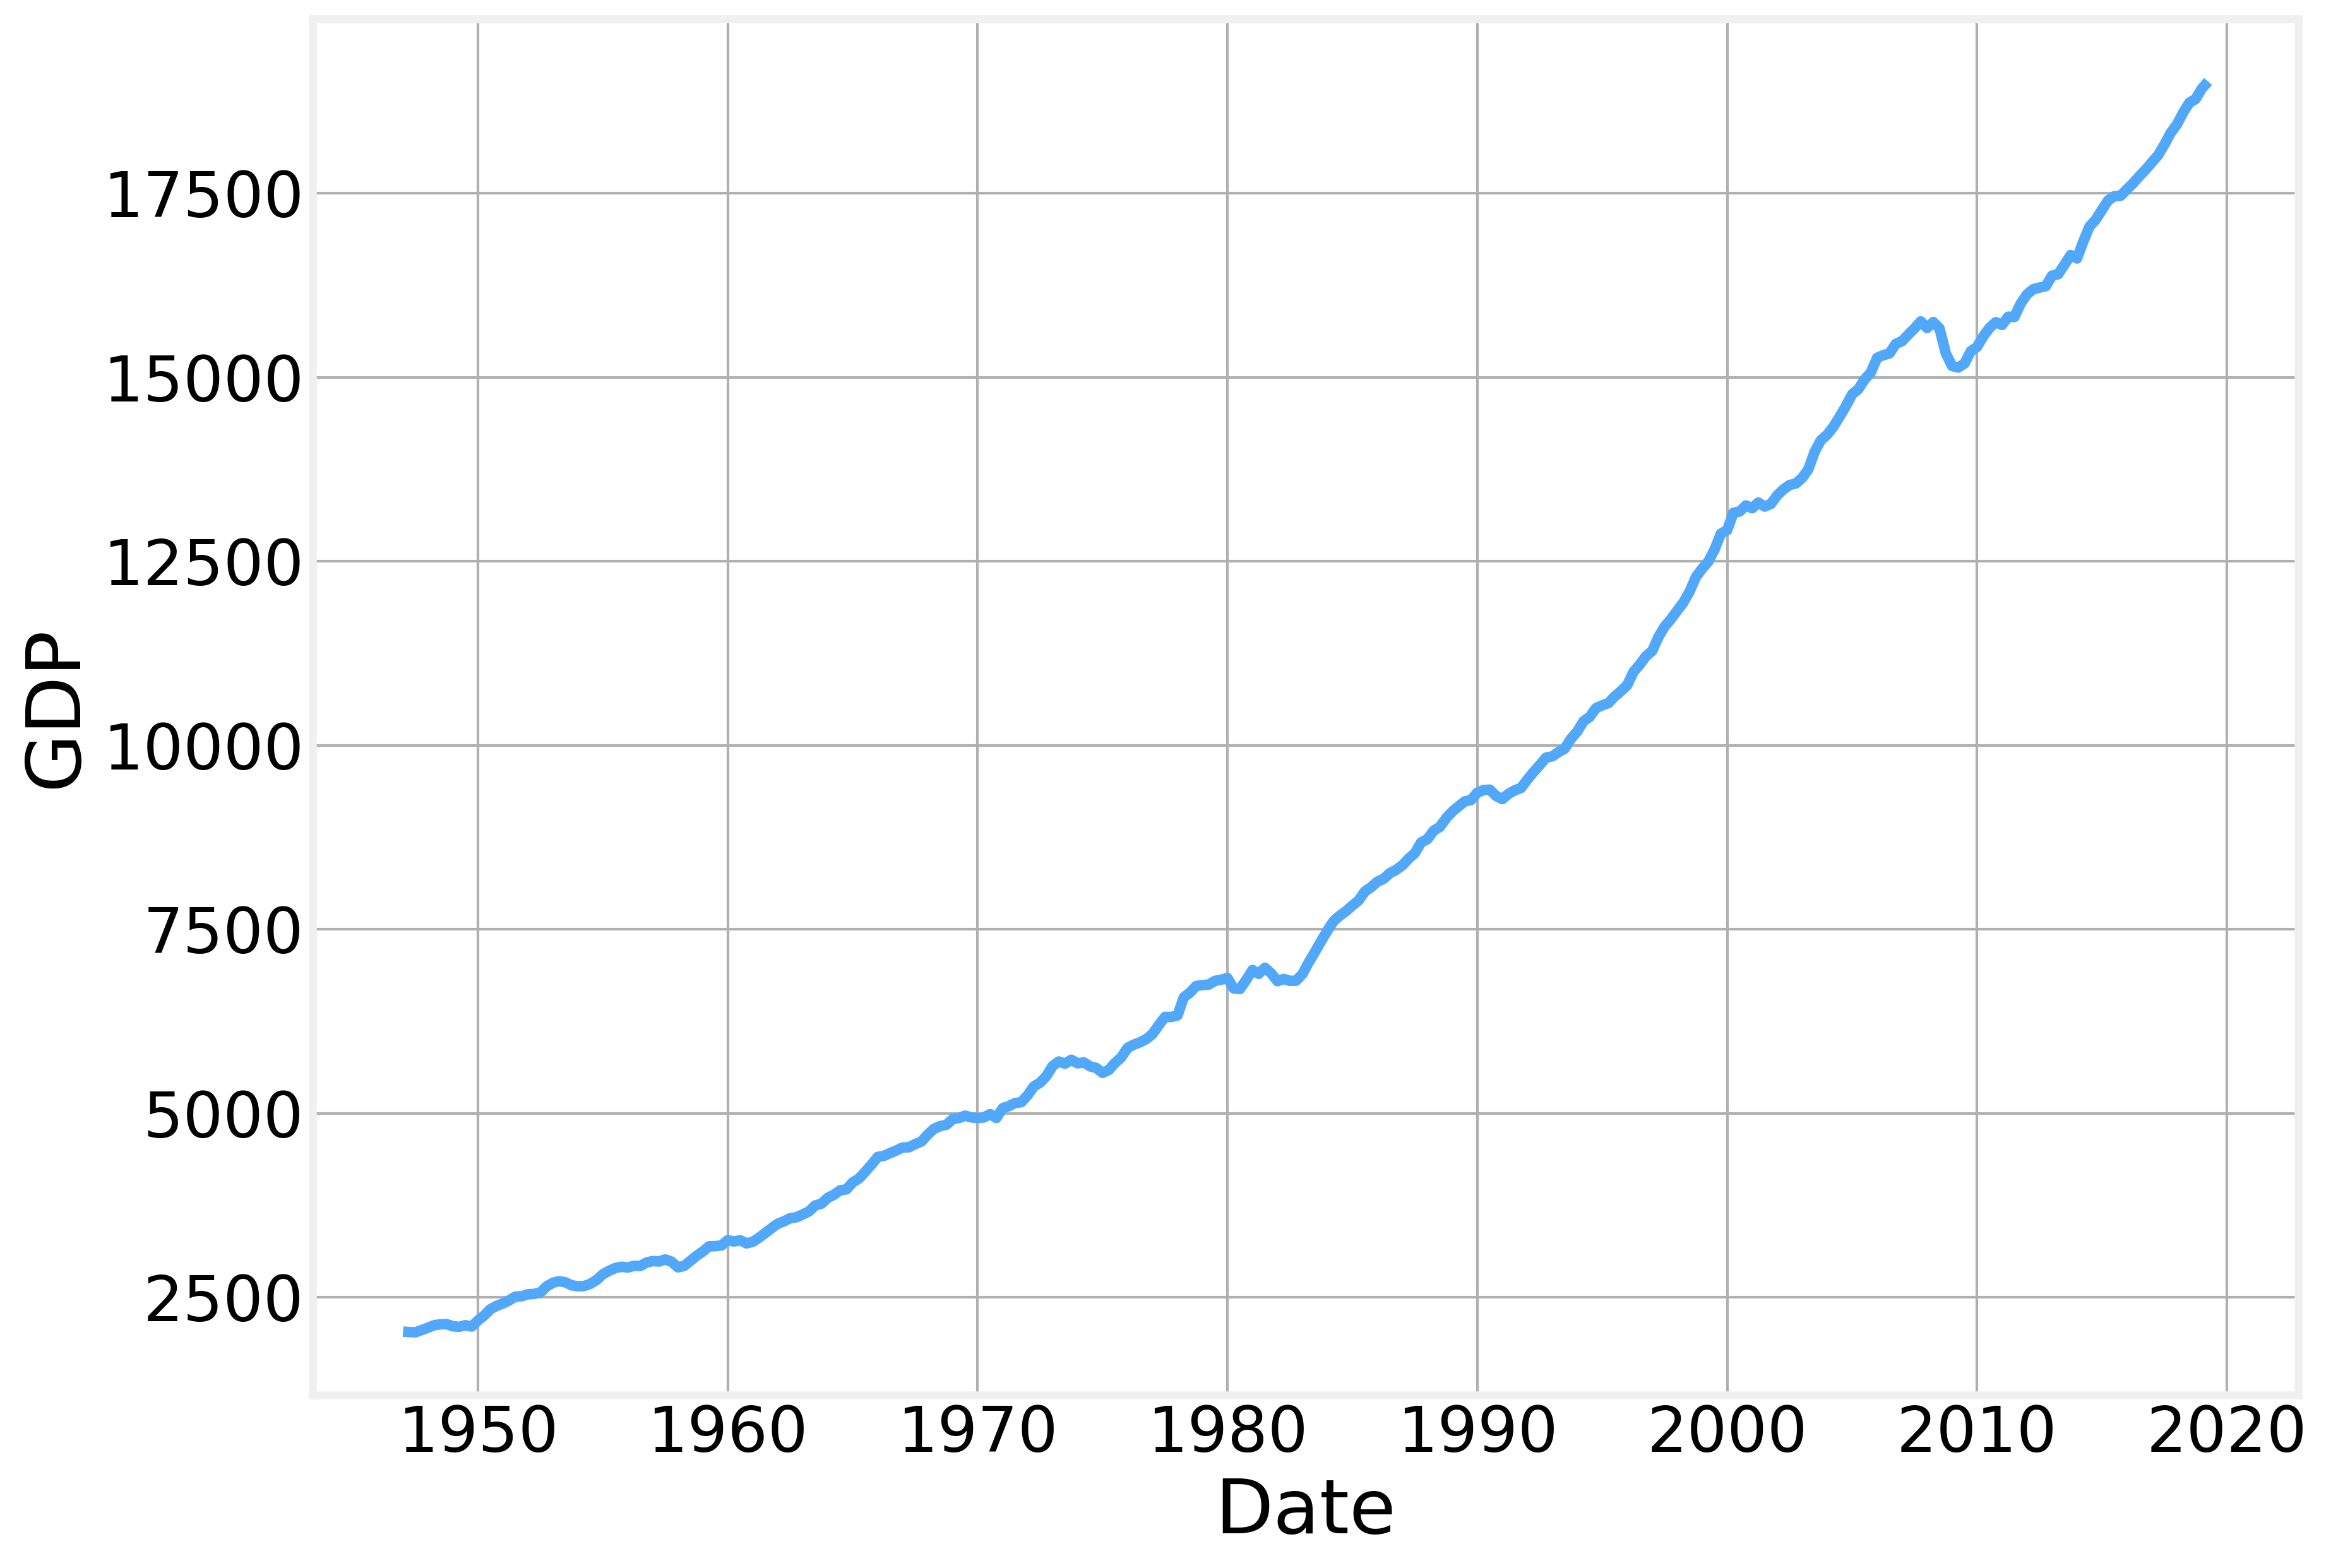

In [5]:
plt.plot(dataset['GDP'])
plt.xlabel('Date')
plt.ylabel('GDP');

You might remember the little "dip" around 2009.

## Calculate the QoQ growth
The outputs of a SimpleRNN are generated by an tanh function. Here we limit the values of our timeseries to be within [-1, 1] to avoid numerical issues. This also has the added advantage of making the timeseries (relatively) stationary

In [6]:
dataset['diff'] = 0
series = dataset['GDP'].pct_change().dropna().values.reshape(-1,1)
dataset.loc[1:, 'diff']=series

A quick plot...

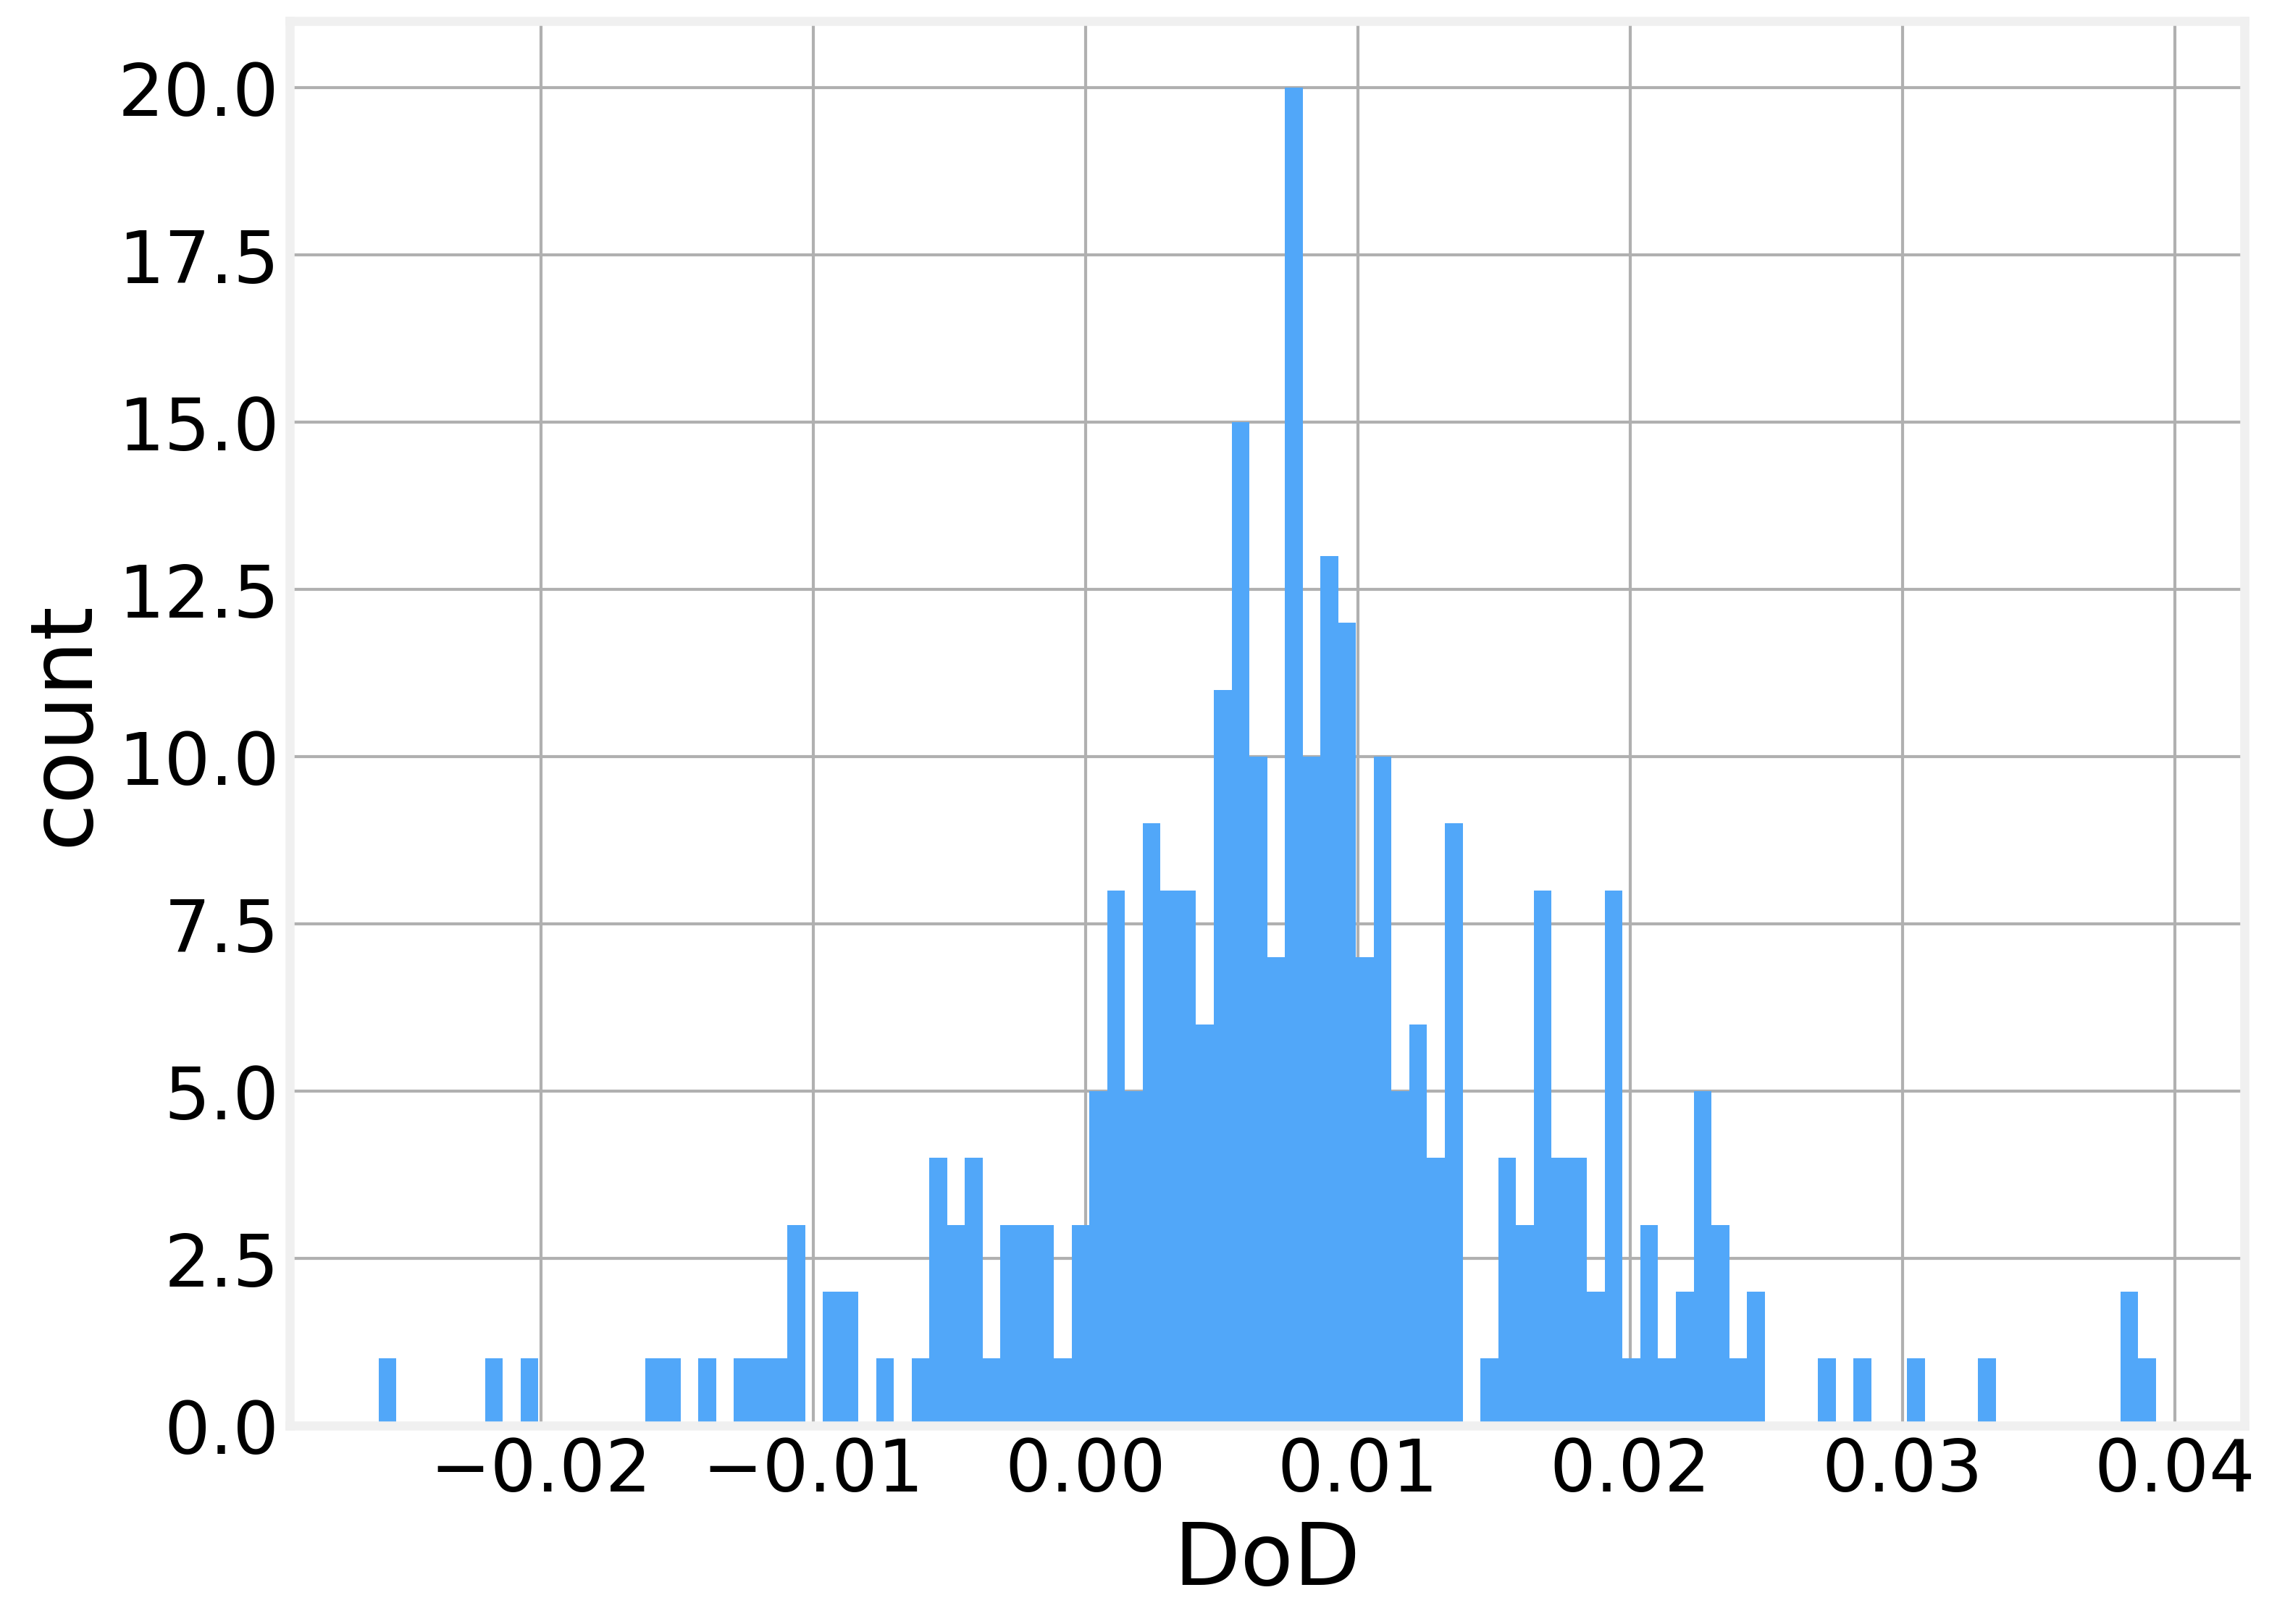

In [7]:
dataset['diff'].hist(bins=100)
plt.xlabel('DoD')
plt.ylabel('count')
plt.gcf().set_size_inches(11, 8)

## Training and Testing datasets 
The y values are just the next x value

In [8]:
values = series.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)
X = values[:-1]
y = values[1:]

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [9]:
n_points = len(series)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points], X[train_points:]
y_train, y_test = y[:train_points], y[train_points:]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 193 training points and 95 testing points


The SimpleRNN model expects a 3D ([samples, time steps, features]) dataset so we reshape them accordingly 

In [10]:
#tf.reset_default_graph()
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(193, 1, 1)
(95, 1, 1)


We're only using one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [11]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [12]:
nb_epoch = 100

model.fit(X_train, y_train, epochs=nb_epoch, batch_size=16)

Epoch 1/100
193/193 [==============================] - 0s 1ms/step - loss: 0.1500
Epoch 2/100
193/193 [==============================] - 0s 110us/step - loss: 0.1371
Epoch 3/100
193/193 [==============================] - 0s 107us/step - loss: 0.1273
Epoch 4/100
193/193 [==============================] - 0s 124us/step - loss: 0.1181
Epoch 5/100
193/193 [==============================] - 0s 107us/step - loss: 0.1114
Epoch 6/100
193/193 [==============================] - 0s 102us/step - loss: 0.1065
Epoch 7/100
193/193 [==============================] - 0s 119us/step - loss: 0.1017
Epoch 8/100
193/193 [==============================] - 0s 106us/step - loss: 0.0987
Epoch 9/100
193/193 [==============================] - 0s 99us/step - loss: 0.0970
Epoch 10/100
193/193 [==============================] - 0s 110us/step - loss: 0.0957
Epoch 11/100
193/193 [==============================] - 0s 109us/step - loss: 0.0949
Epoch 12/100
193/193 [==============================] - 0s 108us/step - loss:

Epoch 98/100
193/193 [==============================] - 0s 100us/step - loss: 0.0928
Epoch 99/100
193/193 [==============================] - 0s 95us/step - loss: 0.0926
Epoch 100/100
193/193 [==============================] - 0s 101us/step - loss: 0.0925


## Make predictions

In [13]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

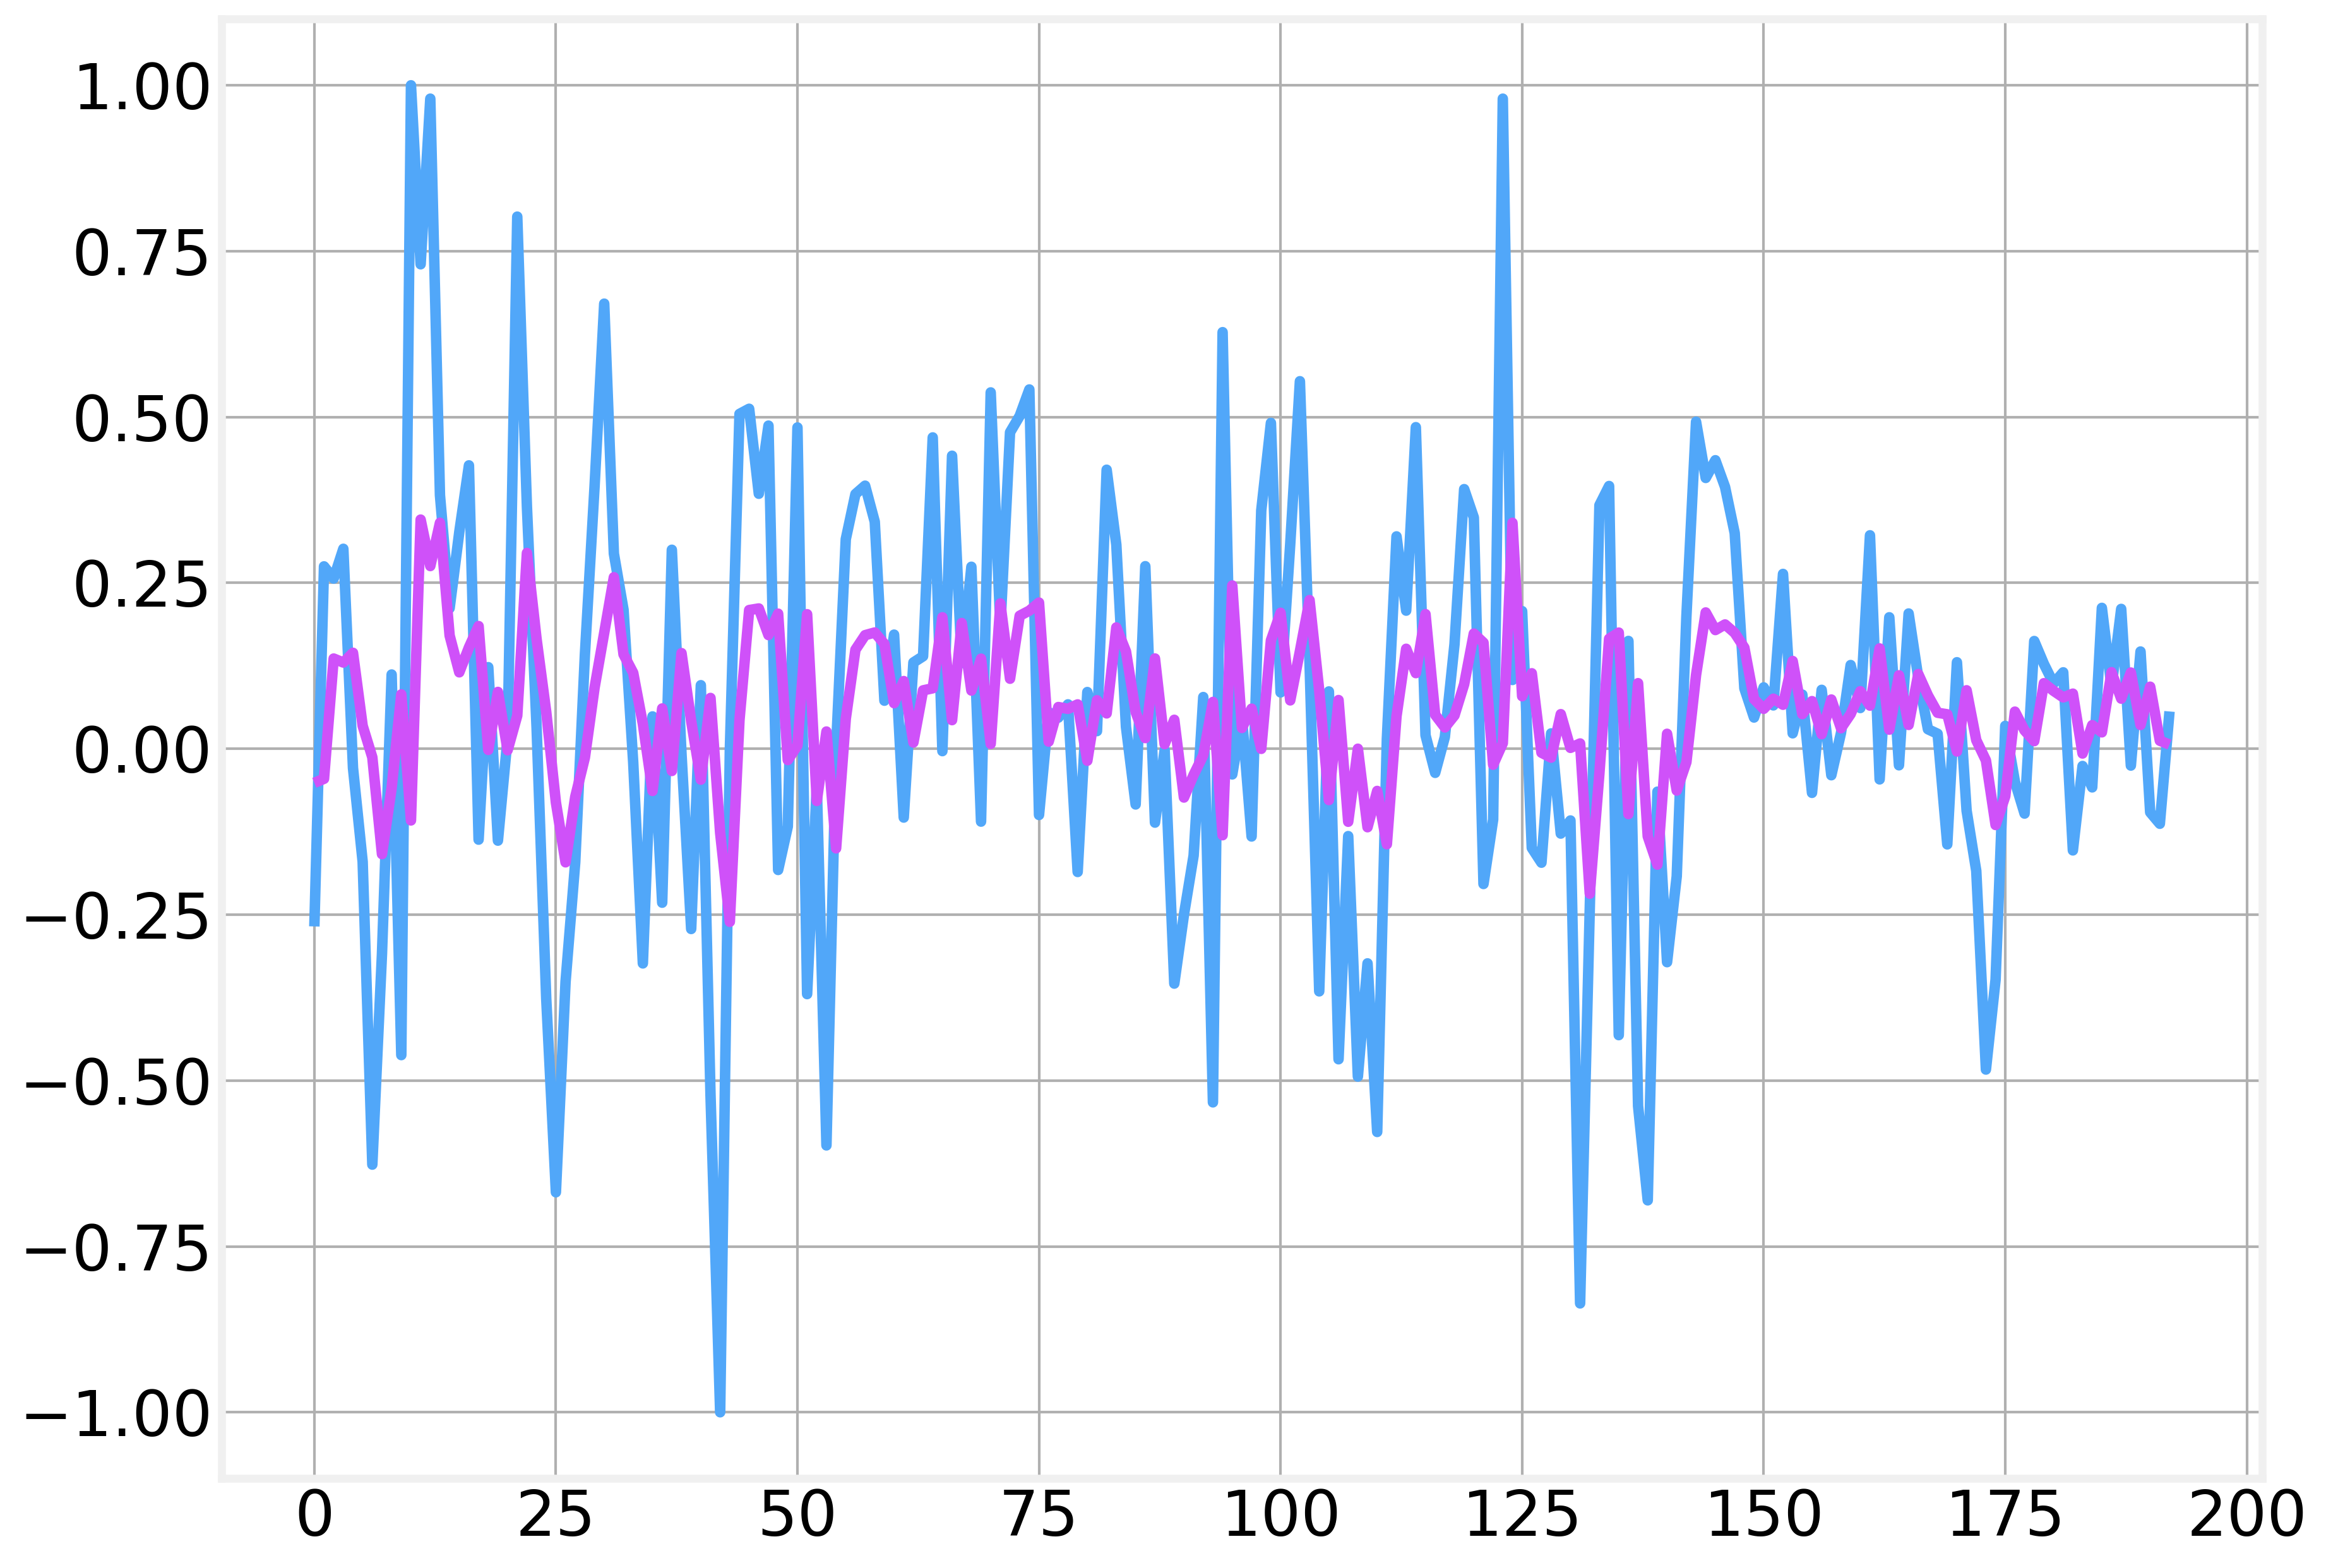

In [14]:
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train_pred)), y_train_pred)

Compute the actual values

In [15]:
dataset['RNN_train_predict'] = 1
dataset['RNN_test_predict'] = 1
dataset.loc[1:train_points+1, 'RNN_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'RNN_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['RNN_train_predict'] = dataset.iloc[0]['GDP']*dataset['RNN_train_predict'].cumprod()
dataset['RNN_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['RNN_test_predict'].cumprod()

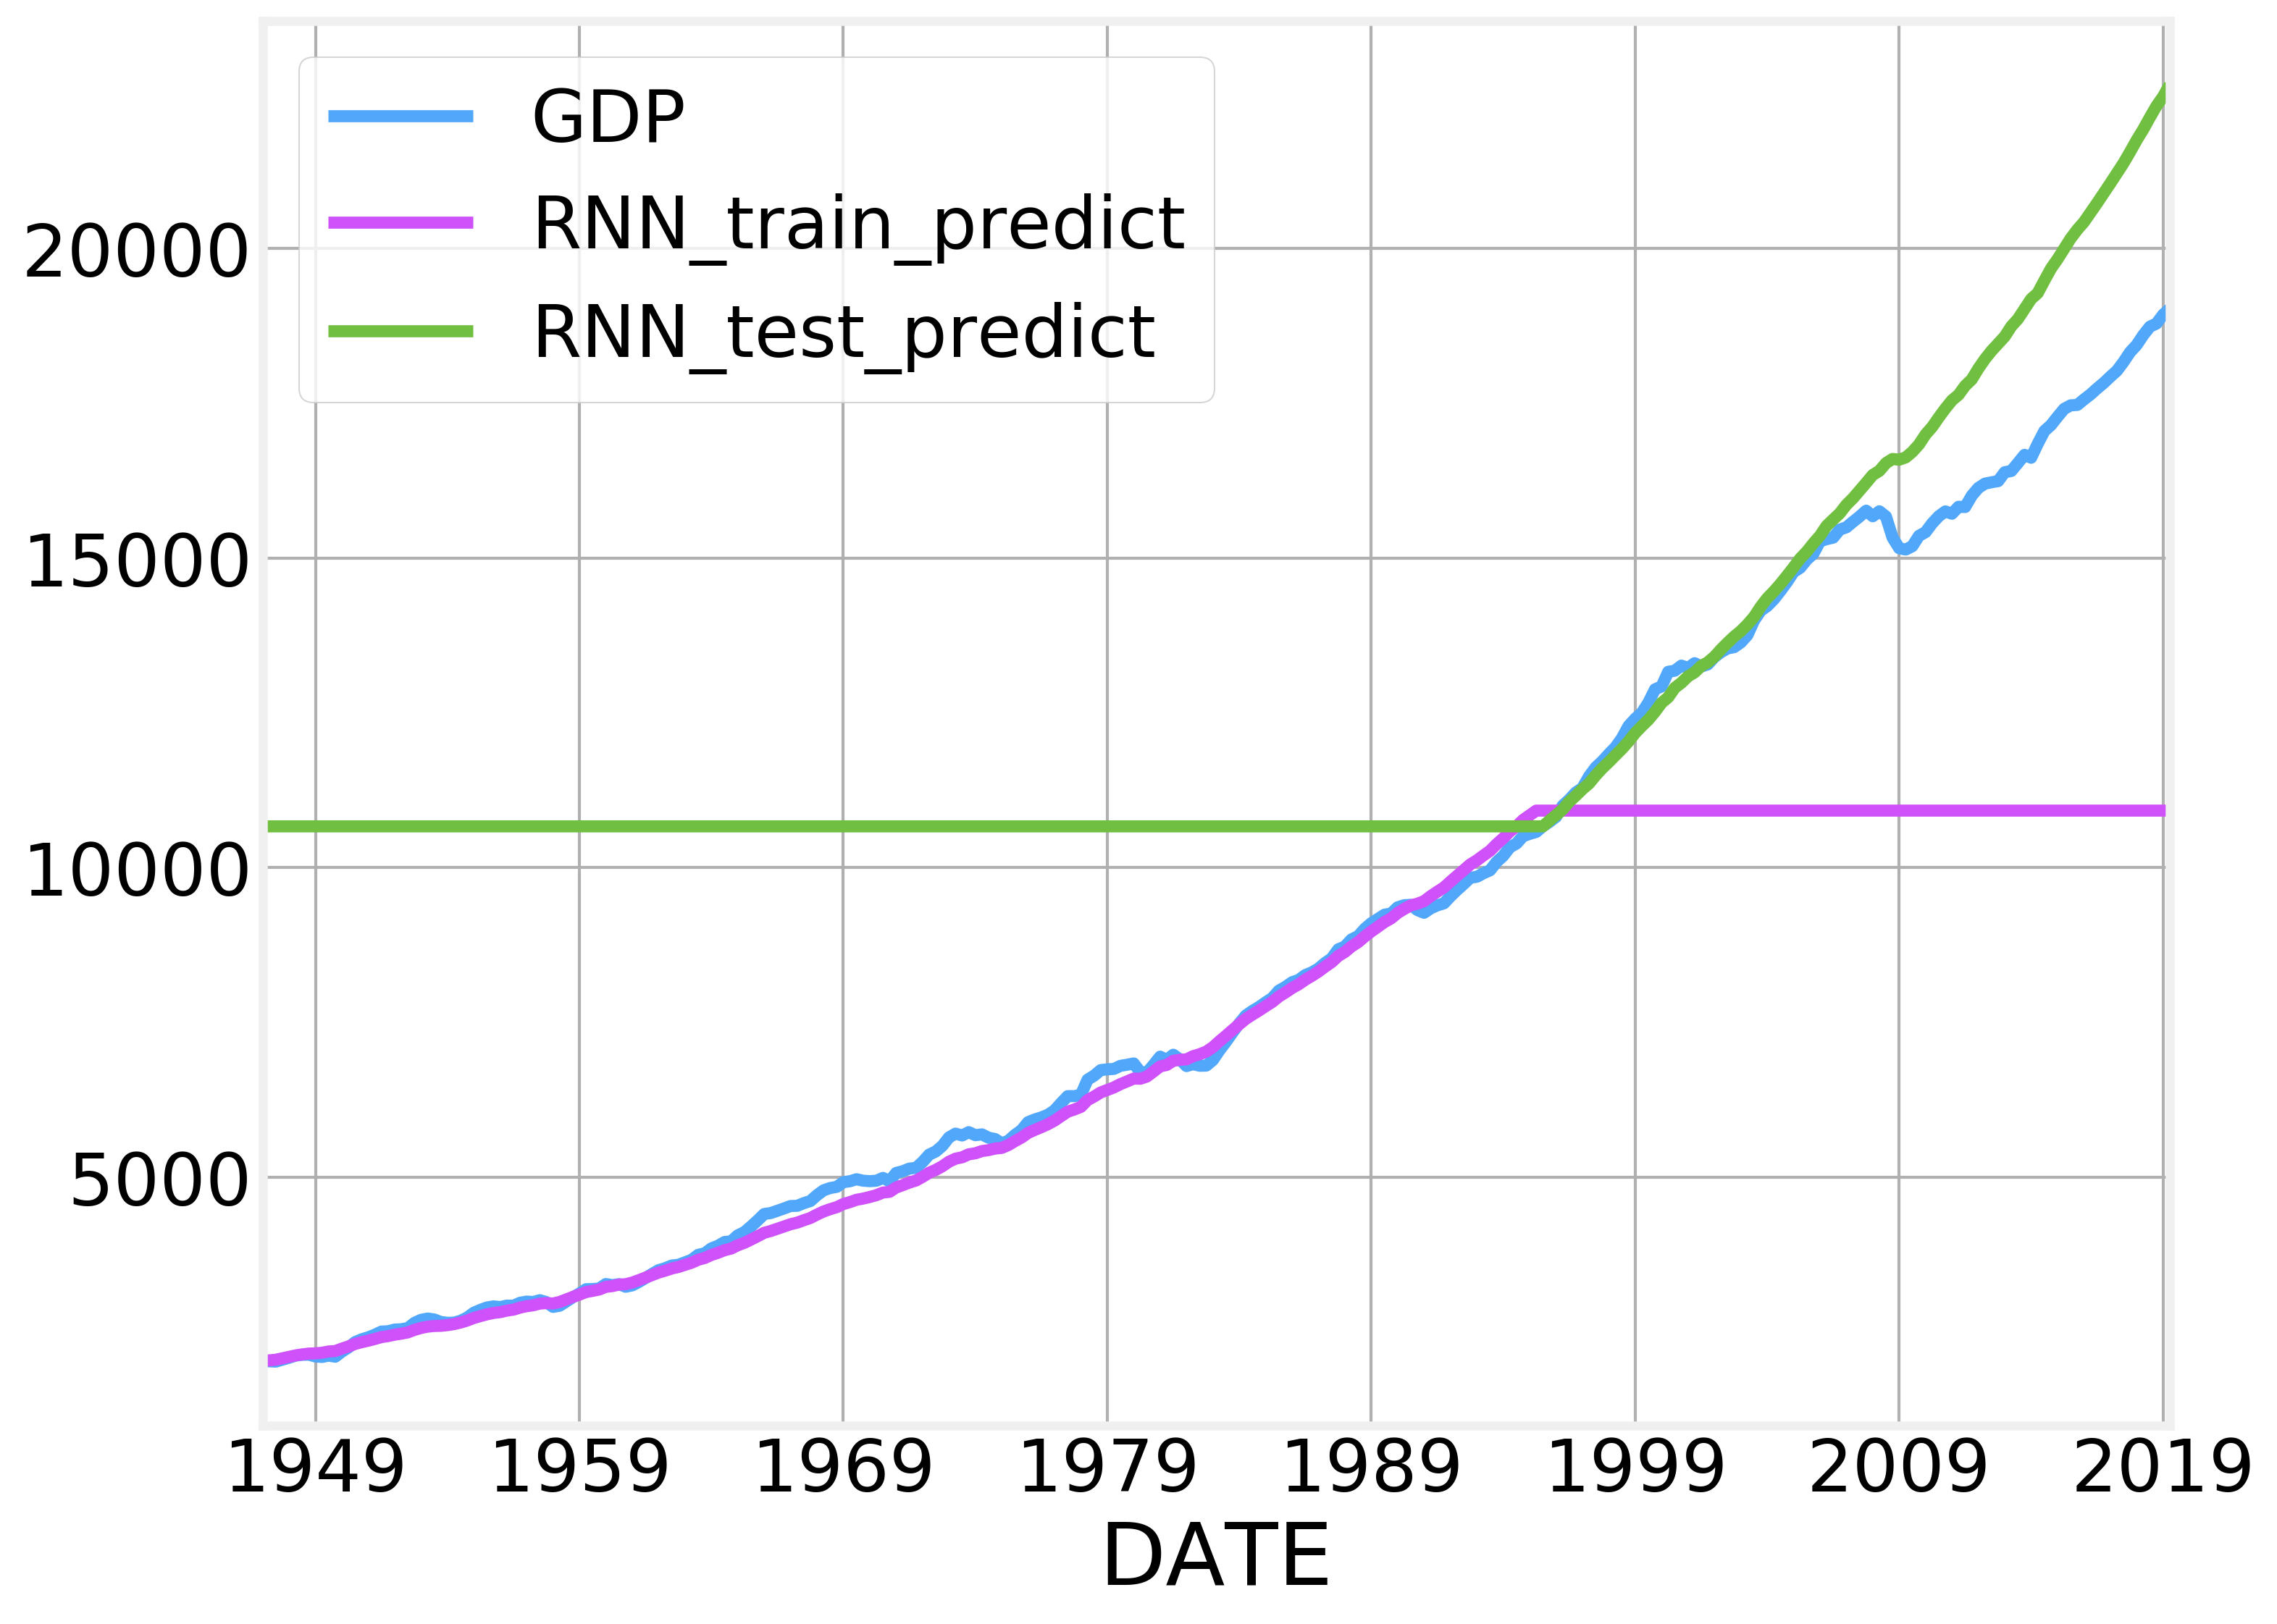

In [16]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

## LSTM
Let's now try using a slightly more sophisticated architecture

In [17]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [19]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
193/193 [==============================] - 0s 2ms/step - loss: 0.1096
Epoch 2/500
193/193 [==============================] - 0s 68us/step - loss: 0.1081
Epoch 3/500
193/193 [==============================] - 0s 70us/step - loss: 0.1066
Epoch 4/500
193/193 [==============================] - 0s 74us/step - loss: 0.1053
Epoch 5/500
193/193 [==============================] - 0s 73us/step - loss: 0.1044
Epoch 6/500
193/193 [==============================] - 0s 83us/step - loss: 0.1036
Epoch 7/500
193/193 [==============================] - 0s 79us/step - loss: 0.1030
Epoch 8/500
193/193 [==============================] - 0s 76us/step - loss: 0.1024
Epoch 9/500
193/193 [==============================] - 0s 85us/step - loss: 0.1019
Epoch 10/500
193/193 [==============================] - 0s 83us/step - loss: 0.1016
Epoch 11/500
193/193 [==============================] - 0s 80us/step - loss: 0.1011
Epoch 12/500
193/193 [==============================] - 0s 88us/step - loss: 0.1006
Ep

193/193 [==============================] - 0s 64us/step - loss: 0.0929
Epoch 99/500
193/193 [==============================] - 0s 64us/step - loss: 0.0928
Epoch 100/500
193/193 [==============================] - 0s 65us/step - loss: 0.0928
Epoch 101/500
193/193 [==============================] - 0s 66us/step - loss: 0.0928
Epoch 102/500
193/193 [==============================] - 0s 68us/step - loss: 0.0928
Epoch 103/500
193/193 [==============================] - 0s 70us/step - loss: 0.0927
Epoch 104/500
193/193 [==============================] - 0s 64us/step - loss: 0.0927
Epoch 105/500
193/193 [==============================] - 0s 67us/step - loss: 0.0927
Epoch 106/500
193/193 [==============================] - 0s 64us/step - loss: 0.0927
Epoch 107/500
193/193 [==============================] - 0s 62us/step - loss: 0.0927
Epoch 108/500
193/193 [==============================] - 0s 63us/step - loss: 0.0926
Epoch 109/500
193/193 [==============================] - 0s 63us/step - loss: 0.

193/193 [==============================] - 0s 66us/step - loss: 0.0922
Epoch 195/500
193/193 [==============================] - 0s 66us/step - loss: 0.0922
Epoch 196/500
193/193 [==============================] - 0s 61us/step - loss: 0.0922
Epoch 197/500
193/193 [==============================] - 0s 61us/step - loss: 0.0922
Epoch 198/500
193/193 [==============================] - 0s 56us/step - loss: 0.0922
Epoch 199/500
193/193 [==============================] - 0s 67us/step - loss: 0.0922
Epoch 200/500
193/193 [==============================] - 0s 59us/step - loss: 0.0922
Epoch 201/500
193/193 [==============================] - 0s 58us/step - loss: 0.0922
Epoch 202/500
193/193 [==============================] - 0s 63us/step - loss: 0.0922
Epoch 203/500
193/193 [==============================] - 0s 63us/step - loss: 0.0922
Epoch 204/500
193/193 [==============================] - 0s 62us/step - loss: 0.0922
Epoch 205/500
193/193 [==============================] - 0s 61us/step - loss: 0

193/193 [==============================] - 0s 86us/step - loss: 0.0923
Epoch 291/500
193/193 [==============================] - 0s 70us/step - loss: 0.0923
Epoch 292/500
193/193 [==============================] - 0s 73us/step - loss: 0.0923
Epoch 293/500
193/193 [==============================] - 0s 70us/step - loss: 0.0923
Epoch 294/500
193/193 [==============================] - 0s 56us/step - loss: 0.0923
Epoch 295/500
193/193 [==============================] - 0s 56us/step - loss: 0.0924
Epoch 296/500
193/193 [==============================] - 0s 65us/step - loss: 0.0923
Epoch 297/500
193/193 [==============================] - 0s 67us/step - loss: 0.0922
Epoch 298/500
193/193 [==============================] - 0s 65us/step - loss: 0.0923
Epoch 299/500
193/193 [==============================] - 0s 61us/step - loss: 0.0921
Epoch 300/500
193/193 [==============================] - 0s 66us/step - loss: 0.0922
Epoch 301/500
193/193 [==============================] - 0s 59us/step - loss: 0

193/193 [==============================] - 0s 64us/step - loss: 0.0921
Epoch 387/500
193/193 [==============================] - 0s 57us/step - loss: 0.0921
Epoch 388/500
193/193 [==============================] - 0s 58us/step - loss: 0.0921
Epoch 389/500
193/193 [==============================] - 0s 60us/step - loss: 0.0921
Epoch 390/500
193/193 [==============================] - 0s 56us/step - loss: 0.0921
Epoch 391/500
193/193 [==============================] - 0s 57us/step - loss: 0.0921
Epoch 392/500
193/193 [==============================] - 0s 58us/step - loss: 0.0922
Epoch 393/500
193/193 [==============================] - 0s 67us/step - loss: 0.0922
Epoch 394/500
193/193 [==============================] - 0s 59us/step - loss: 0.0922
Epoch 395/500
193/193 [==============================] - 0s 63us/step - loss: 0.0923
Epoch 396/500
193/193 [==============================] - 0s 63us/step - loss: 0.0923
Epoch 397/500
193/193 [==============================] - 0s 73us/step - loss: 0

193/193 [==============================] - 0s 65us/step - loss: 0.0921
Epoch 483/500
193/193 [==============================] - 0s 60us/step - loss: 0.0921
Epoch 484/500
193/193 [==============================] - 0s 66us/step - loss: 0.0921
Epoch 485/500
193/193 [==============================] - 0s 64us/step - loss: 0.0921
Epoch 486/500
193/193 [==============================] - 0s 63us/step - loss: 0.0923
Epoch 487/500
193/193 [==============================] - 0s 75us/step - loss: 0.0923
Epoch 488/500
193/193 [==============================] - 0s 68us/step - loss: 0.0923
Epoch 489/500
193/193 [==============================] - 0s 73us/step - loss: 0.0922
Epoch 490/500
193/193 [==============================] - 0s 67us/step - loss: 0.0922
Epoch 491/500
193/193 [==============================] - 0s 64us/step - loss: 0.0922
Epoch 492/500
193/193 [==============================] - 0s 66us/step - loss: 0.0921
Epoch 493/500
193/193 [==============================] - 0s 60us/step - loss: 0

In [20]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['LSTM_train_predict'] = 1
dataset['LSTM_test_predict'] = 1
dataset.loc[1:train_points+1, 'LSTM_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'LSTM_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM_train_predict'].cumprod()
dataset['LSTM_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM_test_predict'].cumprod()

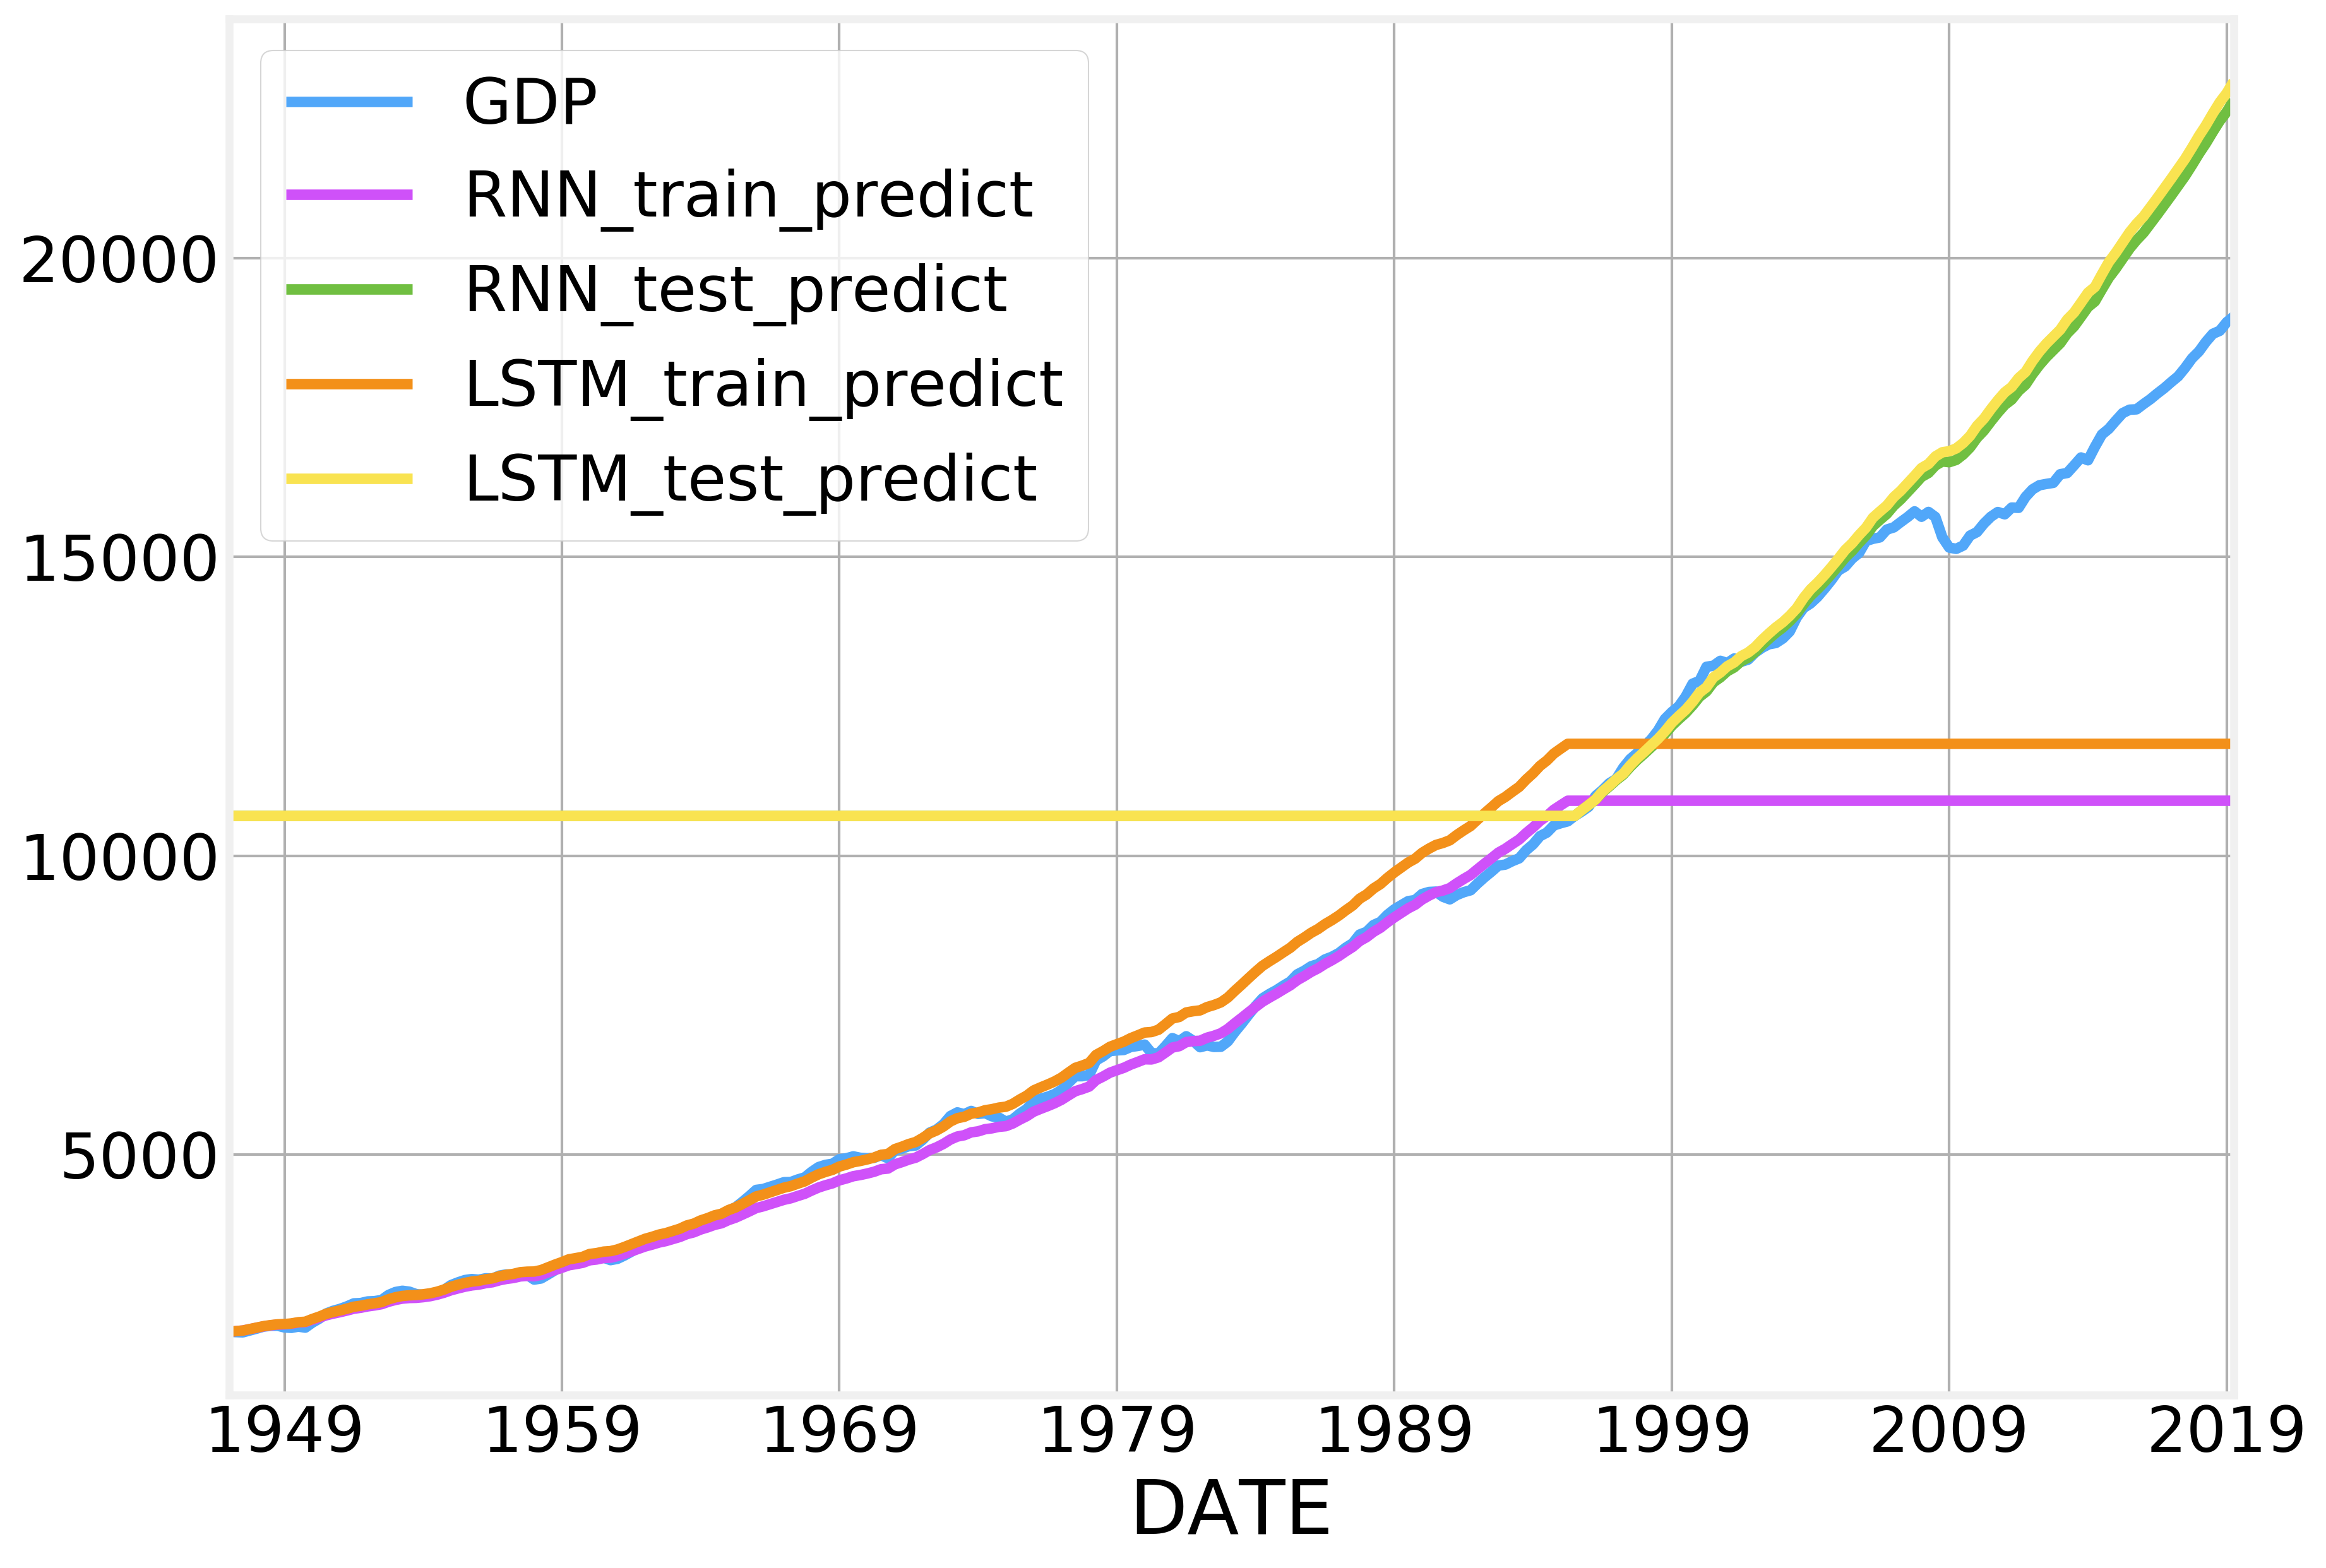

In [21]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict', 'LSTM_train_predict', 'LSTM_test_predict']].plot()

## Multiple timesteps
So far we've been using architectures with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

In [22]:
X2 = np.concatenate([X[0:-4], X[1:-3], X[2:-2], X[3:-1]], axis=1)
y2 = X[4:]

X2_train, X2_test = X2[:train_points], X2[train_points:]
y2_train, y2_test = y2[:train_points], y2[train_points:]

print("We have", X2_train.shape[0], "training points and", X2_test.shape[0], "testing points")

We have 193 training points and 91 testing points


The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

In [23]:
#tf.reset_default_graph()
keras.backend.clear_session()

X2_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1], 1)
X2_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1], 1)
print(X2_train.shape)
print(X2_test.shape)

(193, 4, 1)
(91, 4, 1)


But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

In [24]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [25]:
nb_epoch = 500
model.fit(X2_train, y2_train, epochs=nb_epoch, batch_size=12)

Epoch 1/500
193/193 [==============================] - 0s 2ms/step - loss: 0.1160
Epoch 2/500
193/193 [==============================] - 0s 307us/step - loss: 0.1097
Epoch 3/500
193/193 [==============================] - 0s 292us/step - loss: 0.1068
Epoch 4/500
193/193 [==============================] - 0s 282us/step - loss: 0.1050
Epoch 5/500
193/193 [==============================] - 0s 278us/step - loss: 0.1032
Epoch 6/500
193/193 [==============================] - 0s 272us/step - loss: 0.1019
Epoch 7/500
193/193 [==============================] - 0s 270us/step - loss: 0.1008
Epoch 8/500
193/193 [==============================] - 0s 252us/step - loss: 0.1004
Epoch 9/500
193/193 [==============================] - 0s 241us/step - loss: 0.0998
Epoch 10/500
193/193 [==============================] - 0s 229us/step - loss: 0.0989
Epoch 11/500
193/193 [==============================] - 0s 237us/step - loss: 0.0983
Epoch 12/500
193/193 [==============================] - 0s 240us/step - loss

193/193 [==============================] - 0s 220us/step - loss: 0.0883
Epoch 98/500
193/193 [==============================] - 0s 218us/step - loss: 0.0882
Epoch 99/500
193/193 [==============================] - 0s 218us/step - loss: 0.0881
Epoch 100/500
193/193 [==============================] - 0s 217us/step - loss: 0.0881
Epoch 101/500
193/193 [==============================] - 0s 231us/step - loss: 0.0883
Epoch 102/500
193/193 [==============================] - 0s 218us/step - loss: 0.0880
Epoch 103/500
193/193 [==============================] - 0s 223us/step - loss: 0.0884
Epoch 104/500
193/193 [==============================] - 0s 219us/step - loss: 0.0879
Epoch 105/500
193/193 [==============================] - 0s 215us/step - loss: 0.0881
Epoch 106/500
193/193 [==============================] - 0s 220us/step - loss: 0.0880
Epoch 107/500
193/193 [==============================] - 0s 235us/step - loss: 0.0880
Epoch 108/500
193/193 [==============================] - 0s 230us/step

193/193 [==============================] - 0s 209us/step - loss: 0.0877
Epoch 193/500
193/193 [==============================] - 0s 238us/step - loss: 0.0875
Epoch 194/500
193/193 [==============================] - 0s 215us/step - loss: 0.0878
Epoch 195/500
193/193 [==============================] - 0s 509us/step - loss: 0.0876
Epoch 196/500
193/193 [==============================] - 0s 293us/step - loss: 0.0876
Epoch 197/500
193/193 [==============================] - 0s 214us/step - loss: 0.0882
Epoch 198/500
193/193 [==============================] - 0s 224us/step - loss: 0.0879
Epoch 199/500
193/193 [==============================] - 0s 211us/step - loss: 0.0877
Epoch 200/500
193/193 [==============================] - 0s 203us/step - loss: 0.0879
Epoch 201/500
193/193 [==============================] - 0s 216us/step - loss: 0.0878
Epoch 202/500
193/193 [==============================] - 0s 226us/step - loss: 0.0877
Epoch 203/500
193/193 [==============================] - 0s 214us/st

193/193 [==============================] - 0s 210us/step - loss: 0.0873
Epoch 288/500
193/193 [==============================] - 0s 226us/step - loss: 0.0875
Epoch 289/500
193/193 [==============================] - 0s 213us/step - loss: 0.0876
Epoch 290/500
193/193 [==============================] - 0s 234us/step - loss: 0.0874
Epoch 291/500
193/193 [==============================] - 0s 257us/step - loss: 0.0874
Epoch 292/500
193/193 [==============================] - 0s 241us/step - loss: 0.0878
Epoch 293/500
193/193 [==============================] - 0s 237us/step - loss: 0.0876
Epoch 294/500
193/193 [==============================] - 0s 309us/step - loss: 0.0877
Epoch 295/500
193/193 [==============================] - 0s 283us/step - loss: 0.0876
Epoch 296/500
193/193 [==============================] - 0s 353us/step - loss: 0.0875
Epoch 297/500
193/193 [==============================] - 0s 259us/step - loss: 0.0879
Epoch 298/500
193/193 [==============================] - 0s 250us/st

193/193 [==============================] - 0s 224us/step - loss: 0.0873
Epoch 383/500
193/193 [==============================] - 0s 223us/step - loss: 0.0871
Epoch 384/500
193/193 [==============================] - 0s 221us/step - loss: 0.0873
Epoch 385/500
193/193 [==============================] - 0s 222us/step - loss: 0.0873
Epoch 386/500
193/193 [==============================] - 0s 218us/step - loss: 0.0872
Epoch 387/500
193/193 [==============================] - 0s 239us/step - loss: 0.0871
Epoch 388/500
193/193 [==============================] - 0s 226us/step - loss: 0.0872
Epoch 389/500
193/193 [==============================] - 0s 218us/step - loss: 0.0871
Epoch 390/500
193/193 [==============================] - 0s 237us/step - loss: 0.0870
Epoch 391/500
193/193 [==============================] - 0s 224us/step - loss: 0.0869
Epoch 392/500
193/193 [==============================] - 0s 224us/step - loss: 0.0871
Epoch 393/500
193/193 [==============================] - 0s 238us/st

193/193 [==============================] - 0s 235us/step - loss: 0.0866
Epoch 478/500
193/193 [==============================] - 0s 290us/step - loss: 0.0867
Epoch 479/500
193/193 [==============================] - 0s 249us/step - loss: 0.0870
Epoch 480/500
193/193 [==============================] - 0s 237us/step - loss: 0.0870
Epoch 481/500
193/193 [==============================] - 0s 230us/step - loss: 0.0870
Epoch 482/500
193/193 [==============================] - 0s 248us/step - loss: 0.0868
Epoch 483/500
193/193 [==============================] - 0s 291us/step - loss: 0.0868
Epoch 484/500
193/193 [==============================] - 0s 250us/step - loss: 0.0866
Epoch 485/500
193/193 [==============================] - 0s 236us/step - loss: 0.0866
Epoch 486/500
193/193 [==============================] - 0s 224us/step - loss: 0.0867
Epoch 487/500
193/193 [==============================] - 0s 247us/step - loss: 0.0867
Epoch 488/500
193/193 [==============================] - 0s 245us/st

In [26]:
y_train_pred = model.predict(X2_train)
y_test_pred = model.predict(X2_test)

dataset['LSTM3_train_predict'] = 1
dataset['LSTM3_test_predict'] = 1
dataset.loc[4:train_points+4, 'LSTM3_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+6:, 'LSTM3_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM3_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM3_train_predict'].cumprod()
dataset['LSTM3_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM3_test_predict'].cumprod()

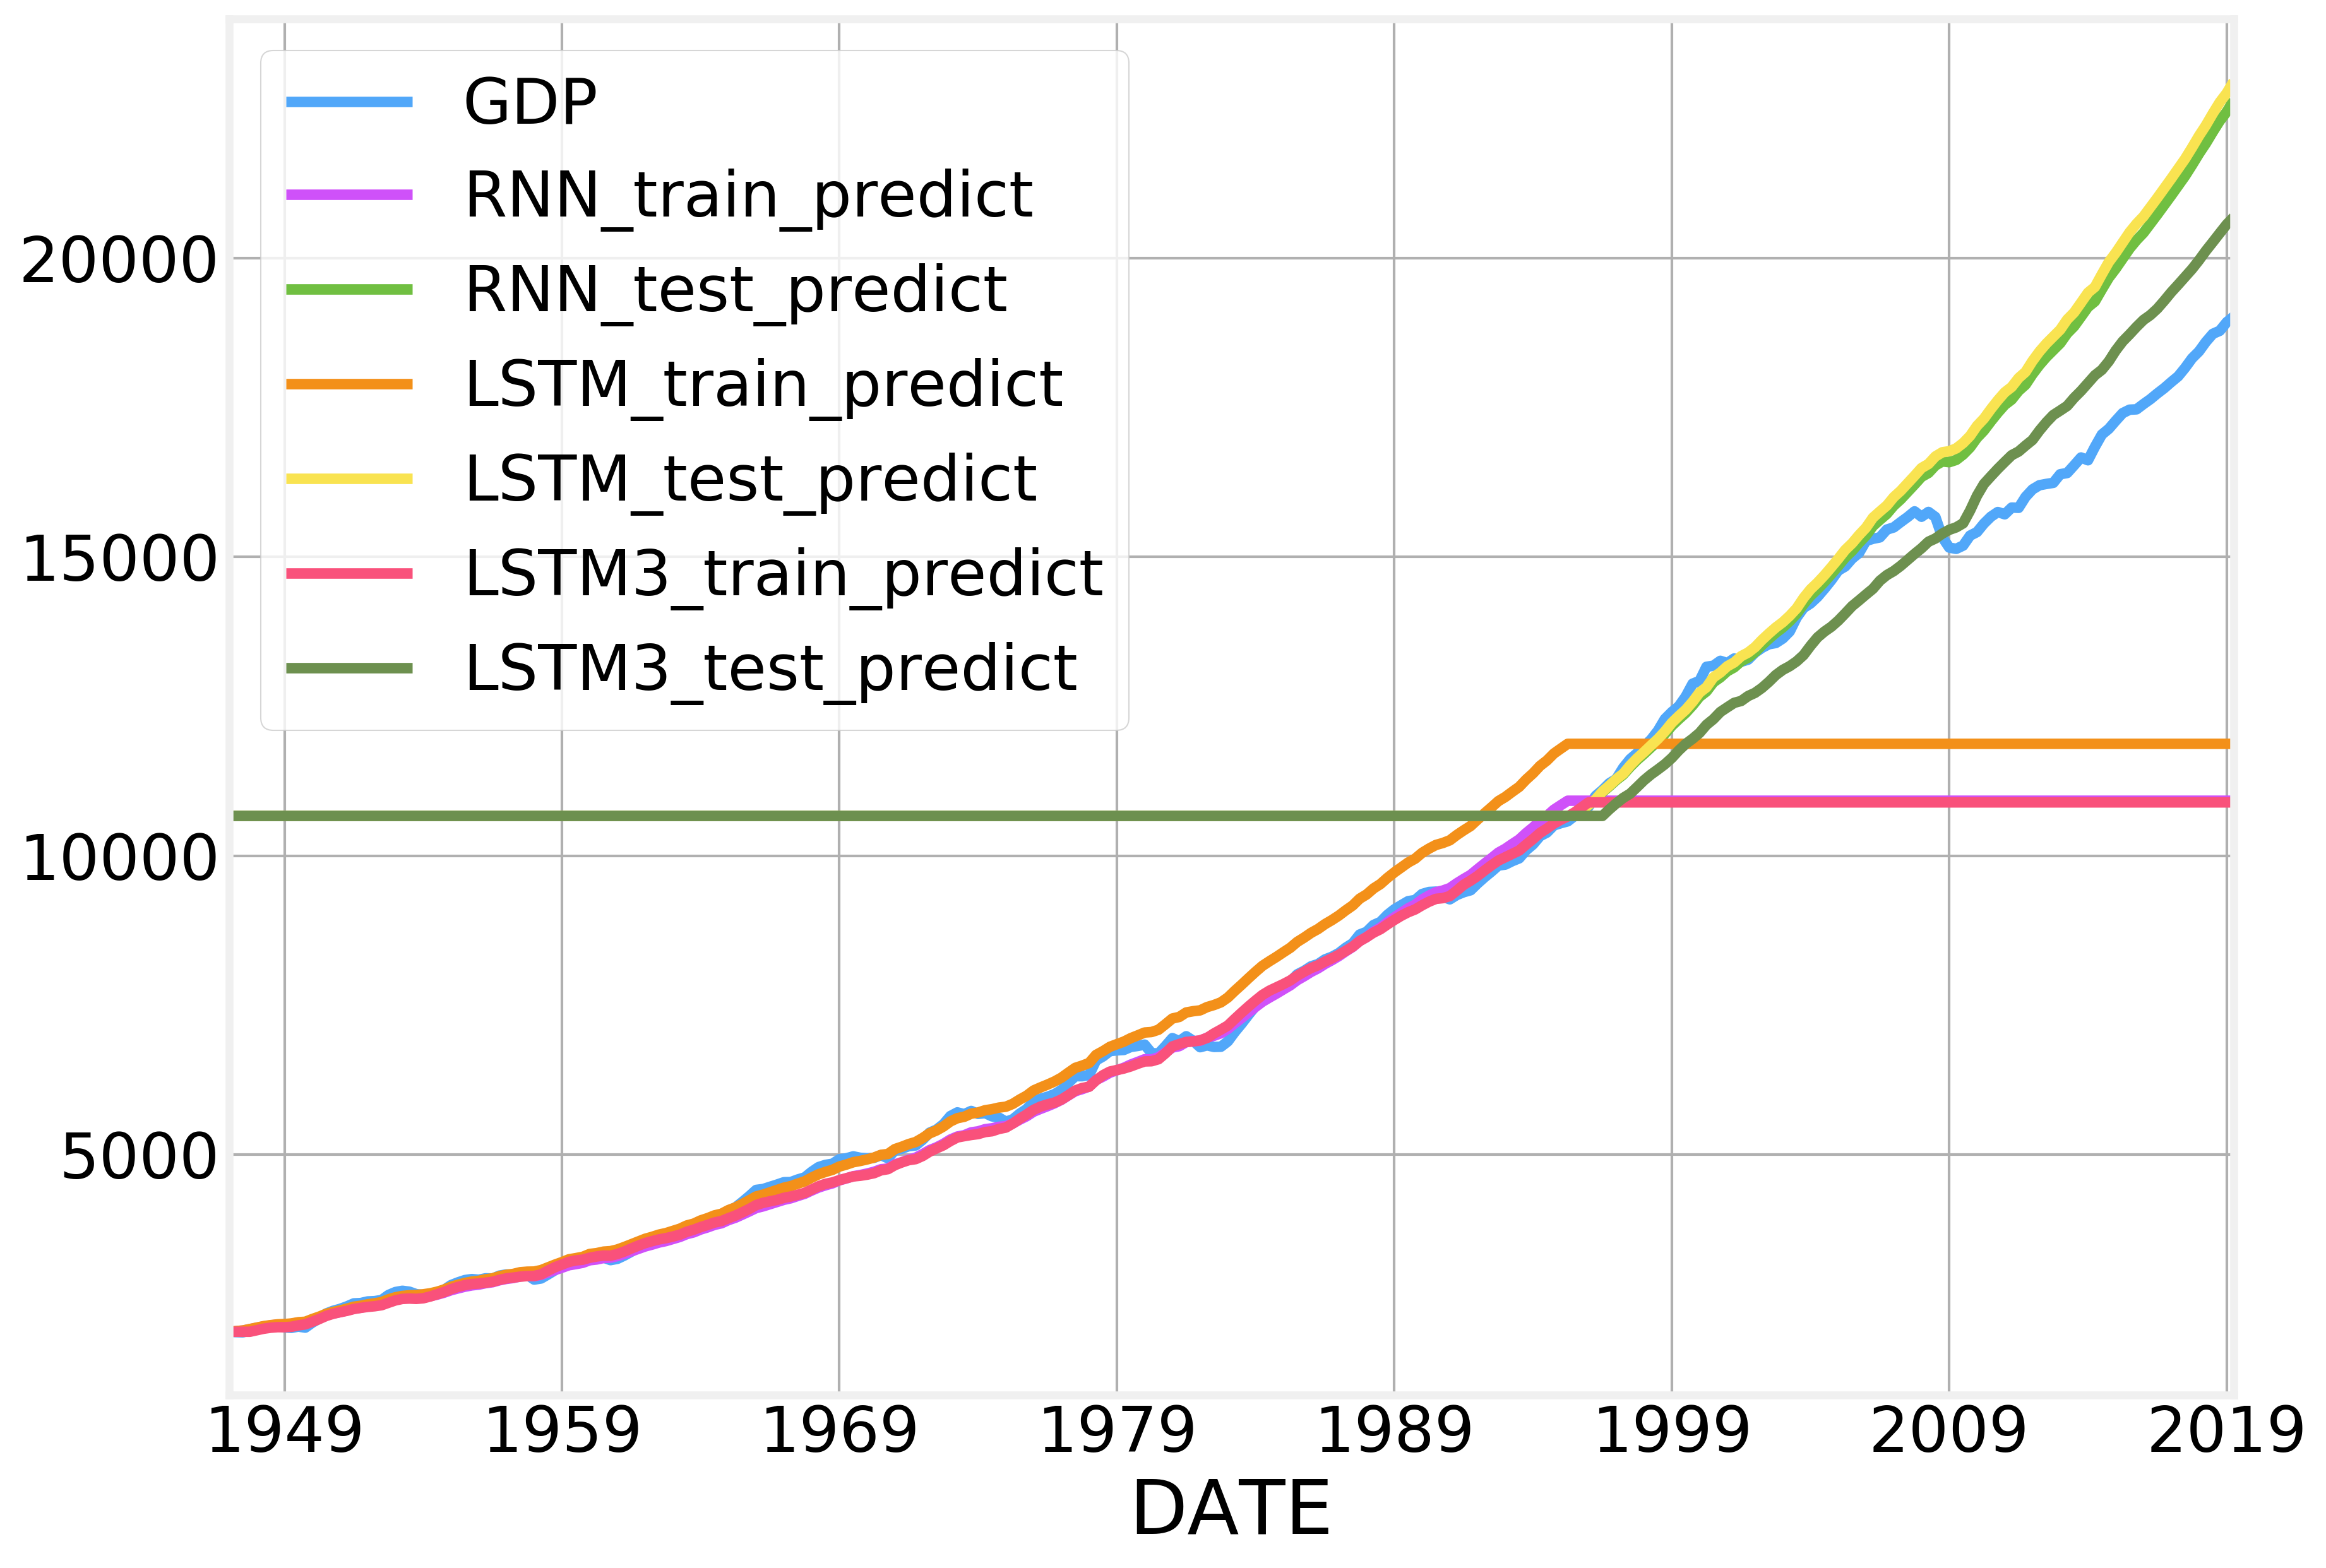

In [27]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict', 
                'LSTM_train_predict', 'LSTM_test_predict', 
                'LSTM3_train_predict', 'LSTM3_test_predict']].plot()

## GRU

In [28]:
model = Sequential()
model.add(GRU(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 4)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


In [30]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
193/193 [==============================] - 1s 3ms/step - loss: 0.1268
Epoch 2/500
193/193 [==============================] - 0s 76us/step - loss: 0.1244
Epoch 3/500
193/193 [==============================] - 0s 77us/step - loss: 0.1220
Epoch 4/500
193/193 [==============================] - 0s 76us/step - loss: 0.1207
Epoch 5/500
193/193 [==============================] - 0s 76us/step - loss: 0.1196
Epoch 6/500
193/193 [==============================] - 0s 72us/step - loss: 0.1185
Epoch 7/500
193/193 [==============================] - 0s 75us/step - loss: 0.1175
Epoch 8/500
193/193 [==============================] - 0s 74us/step - loss: 0.1165
Epoch 9/500
193/193 [==============================] - 0s 71us/step - loss: 0.1156
Epoch 10/500
193/193 [==============================] - 0s 78us/step - loss: 0.1147
Epoch 11/500
193/193 [==============================] - 0s 81us/step - loss: 0.1136
Epoch 12/500
193/193 [==============================] - 0s 89us/step - loss: 0.1128
Ep

193/193 [==============================] - 0s 71us/step - loss: 0.0924
Epoch 99/500
193/193 [==============================] - 0s 83us/step - loss: 0.0923
Epoch 100/500
193/193 [==============================] - 0s 102us/step - loss: 0.0924
Epoch 101/500
193/193 [==============================] - 0s 130us/step - loss: 0.0923
Epoch 102/500
193/193 [==============================] - 0s 92us/step - loss: 0.0923
Epoch 103/500
193/193 [==============================] - 0s 103us/step - loss: 0.0923
Epoch 104/500
193/193 [==============================] - 0s 117us/step - loss: 0.0922
Epoch 105/500
193/193 [==============================] - 0s 95us/step - loss: 0.0921
Epoch 106/500
193/193 [==============================] - 0s 107us/step - loss: 0.0921
Epoch 107/500
193/193 [==============================] - 0s 110us/step - loss: 0.0922
Epoch 108/500
193/193 [==============================] - 0s 165us/step - loss: 0.0922
Epoch 109/500
193/193 [==============================] - 0s 129us/step - 

193/193 [==============================] - 0s 96us/step - loss: 0.0922
Epoch 195/500
193/193 [==============================] - 0s 99us/step - loss: 0.0923
Epoch 196/500
193/193 [==============================] - 0s 104us/step - loss: 0.0923
Epoch 197/500
193/193 [==============================] - 0s 89us/step - loss: 0.0923
Epoch 198/500
193/193 [==============================] - 0s 103us/step - loss: 0.0922
Epoch 199/500
193/193 [==============================] - 0s 94us/step - loss: 0.0922
Epoch 200/500
193/193 [==============================] - 0s 84us/step - loss: 0.0922
Epoch 201/500
193/193 [==============================] - 0s 84us/step - loss: 0.0921
Epoch 202/500
193/193 [==============================] - 0s 79us/step - loss: 0.0922
Epoch 203/500
193/193 [==============================] - 0s 96us/step - loss: 0.0921
Epoch 204/500
193/193 [==============================] - 0s 95us/step - loss: 0.0921
Epoch 205/500
193/193 [==============================] - 0s 77us/step - loss:

193/193 [==============================] - 0s 118us/step - loss: 0.0921
Epoch 291/500
193/193 [==============================] - 0s 117us/step - loss: 0.0921
Epoch 292/500
193/193 [==============================] - 0s 93us/step - loss: 0.0921
Epoch 293/500
193/193 [==============================] - 0s 95us/step - loss: 0.0921
Epoch 294/500
193/193 [==============================] - 0s 85us/step - loss: 0.0921
Epoch 295/500
193/193 [==============================] - 0s 117us/step - loss: 0.0920
Epoch 296/500
193/193 [==============================] - 0s 109us/step - loss: 0.0920
Epoch 297/500
193/193 [==============================] - 0s 90us/step - loss: 0.0922
Epoch 298/500
193/193 [==============================] - 0s 99us/step - loss: 0.0923
Epoch 299/500
193/193 [==============================] - 0s 86us/step - loss: 0.0923
Epoch 300/500
193/193 [==============================] - 0s 86us/step - loss: 0.0923
Epoch 301/500
193/193 [==============================] - 0s 93us/step - los

Epoch 386/500
193/193 [==============================] - 0s 148us/step - loss: 0.0920
Epoch 387/500
193/193 [==============================] - 0s 111us/step - loss: 0.0921
Epoch 388/500
193/193 [==============================] - 0s 117us/step - loss: 0.0921
Epoch 389/500
193/193 [==============================] - 0s 110us/step - loss: 0.0921
Epoch 390/500
193/193 [==============================] - 0s 129us/step - loss: 0.0919
Epoch 391/500
193/193 [==============================] - 0s 152us/step - loss: 0.0920
Epoch 392/500
193/193 [==============================] - 0s 135us/step - loss: 0.0922
Epoch 393/500
193/193 [==============================] - 0s 124us/step - loss: 0.0920
Epoch 394/500
193/193 [==============================] - 0s 130us/step - loss: 0.0921
Epoch 395/500
193/193 [==============================] - 0s 134us/step - loss: 0.0920
Epoch 396/500
193/193 [==============================] - 0s 159us/step - loss: 0.0921
Epoch 397/500
193/193 [==============================]

193/193 [==============================] - 0s 116us/step - loss: 0.0921
Epoch 482/500
193/193 [==============================] - 0s 108us/step - loss: 0.0920
Epoch 483/500
193/193 [==============================] - 0s 140us/step - loss: 0.0920
Epoch 484/500
193/193 [==============================] - 0s 111us/step - loss: 0.0920
Epoch 485/500
193/193 [==============================] - 0s 110us/step - loss: 0.0920
Epoch 486/500
193/193 [==============================] - 0s 125us/step - loss: 0.0920
Epoch 487/500
193/193 [==============================] - 0s 130us/step - loss: 0.0920
Epoch 488/500
193/193 [==============================] - 0s 102us/step - loss: 0.0920
Epoch 489/500
193/193 [==============================] - 0s 94us/step - loss: 0.0920
Epoch 490/500
193/193 [==============================] - 0s 85us/step - loss: 0.0920
Epoch 491/500
193/193 [==============================] - 0s 100us/step - loss: 0.0920
Epoch 492/500
193/193 [==============================] - 0s 109us/step

In [31]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['GRU_train_predict'] = 1
dataset['GRU_test_predict'] = 1
dataset.loc[1:train_points+1, 'GRU_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'GRU_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['GRU_train_predict'] = dataset.iloc[0]['GDP']*dataset['GRU_train_predict'].cumprod()
dataset['GRU_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['GRU_test_predict'].cumprod()

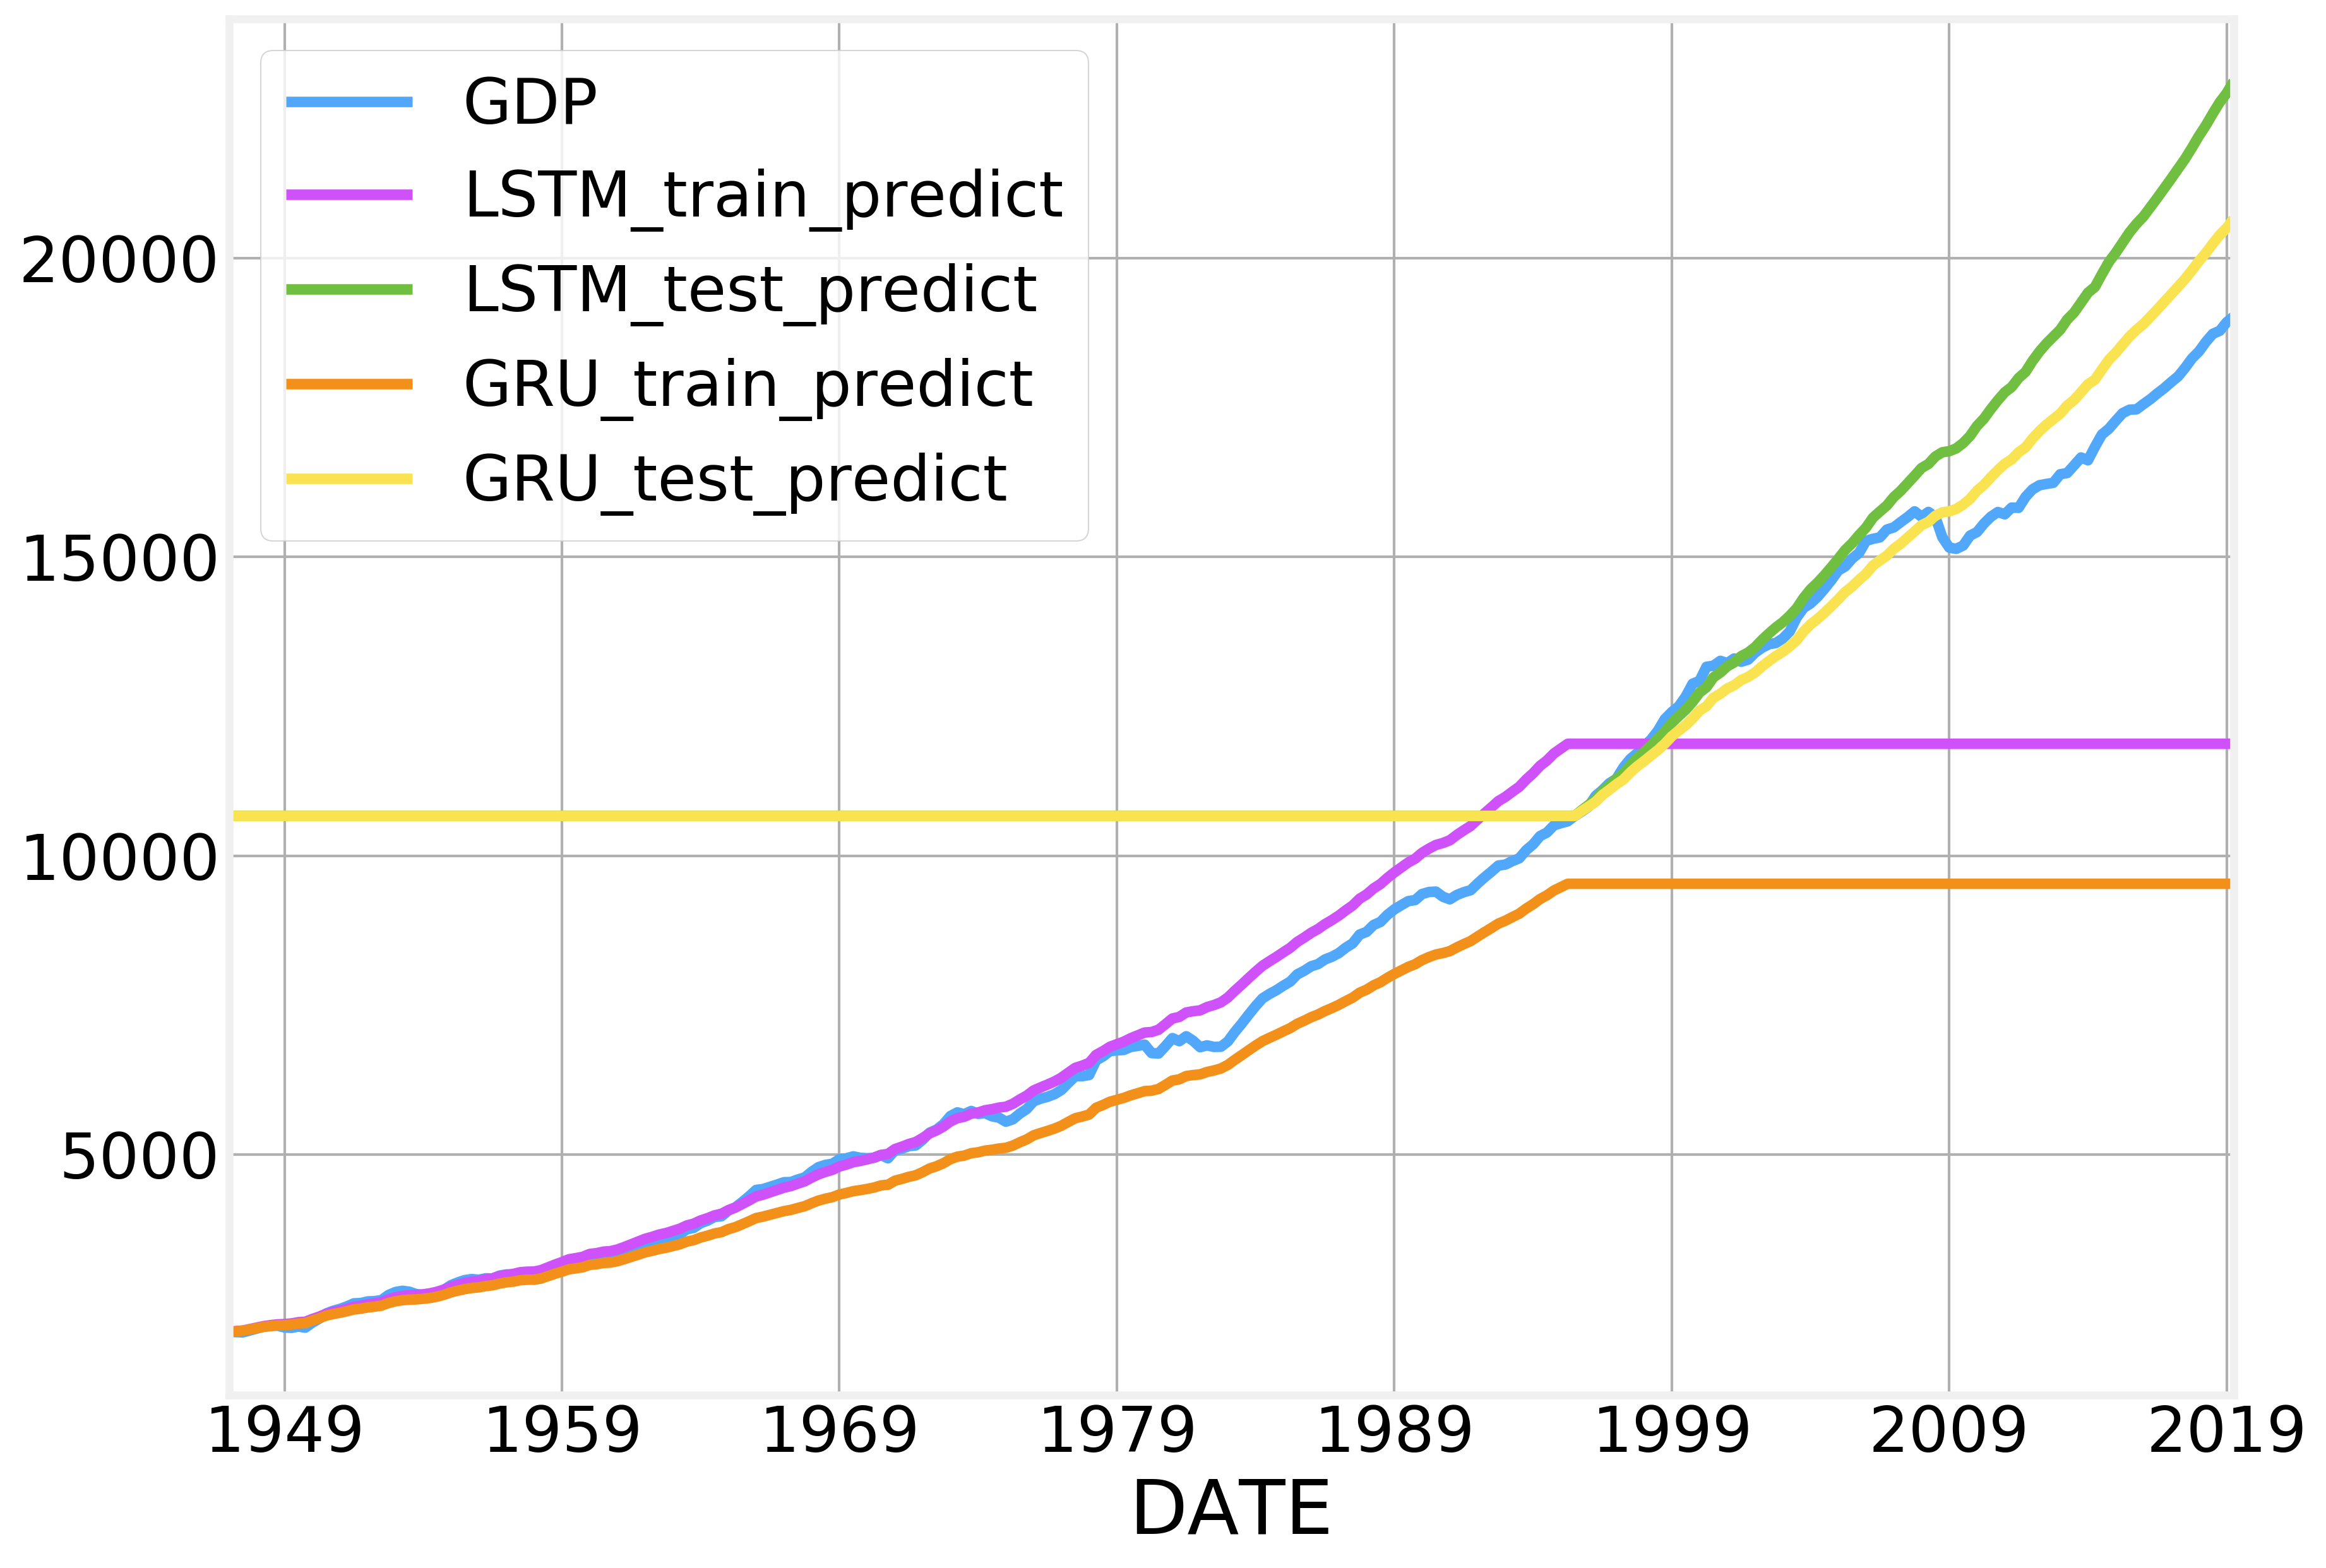

In [32]:
dataset[['GDP', #'RNN_train_predict', 'RNN_test_predict', 
                'LSTM_train_predict', 'LSTM_test_predict', 
                #'LSTM3_train_predict', 'LSTM3_test_predict',
                'GRU_train_predict', 'GRU_test_predict']].plot()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>